<a href="https://colab.research.google.com/github/mashtakovmm/polycode2022/blob/main/baseline_one_morphed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз типа личности

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Введение

В этой записной книжке описаны шаги, которые предприняns для решения задачи EDSA Kaggle «Предсказание профиля личности MBTI».

Согласно описанию задачи, от нас требовалось построить и обучить модель/модели, способные использовать НЛП (обработку естественного языка) для прогнозирования метки MBTI человека, используя только то, что они публикуют на онлайн-форумах.

Условно, каждый тип личности состоит из четырех бинарных переменных:

- Психика: интроверт (И) или экстраверт (Э)
- Природа: формалист (Ф) или любознательный (Л)
- Сознание: небрежный (Н) или пунктуальный (П)
- Нейротизм: уравновешенный (У) или тревожный (Т)

У каждого человека будет только одна из двух категорий для каждой переменной. Объединение четырех переменных дает окончательный тип личности. Например, человек с экстравертным, любознательным, пунктуальным и уравновешенным характером получит тип личности "ЭЛПУ".

Решение должно быть способно предсказывать метки с наименьшей ошибкой для каждой из четырех переменных, т. е. предсказывать четыре отдельные метки для каждого человека, которые при объединении приводят к типу личности этого человека.

#### 1. Предварительная обработка данных

Разведывательный анализ данных (EDA)  
Очистка текста  
Векторизация и латентный семантический анализ  
Построение целевых векторов  

#### 2. Тестирование модели

Построение и сравнение базовых моделей  
Настройка параметров  
Стекирование моделей  
Сравнение настроенной производительности  

#### 3. Прогнозирование

Оформление документов для подачи  
Полученные результаты  
Выводы  

### 1. Предварительная обработка данных

In [140]:
# модули для работы с табличными данными
import numpy as np
import pandas as pd

# модули для получения графиков
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# модули для работы с текстом
import re
import string

# специальные NLP модули
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [141]:
# Следующий код пропускает предупреждения Python из выходных данных
import warnings
warnings.filterwarnings("ignore")

Из домашнего каталога импортируем два набора данных, обучаем и тестируем.

In [142]:
#df = pd.read_csv('train.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/train.csv')
#test = pd.read_csv("../input/test.csv")

### Разведывательный анализ данных (EDA)

In [143]:
df.head(4)

,id,текст,интроверсия/экстраверсия,формализм/любознательность,небрежность/пунктуальность,уравновешенность/тревожность
0,1,Начнем сначала. На картине изображено 2 лица: ...,35,44,38,65
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",35,44,38,65
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",39,41,47,41
3,4,На картине двое: бабушка и внук. Молодость и с...,39,41,47,41


In [144]:
df['психика'] = df['интроверсия/экстраверсия'].apply(lambda x: 'И' if x<50 else 'Э')
df['природа'] = df['формализм/любознательность'].apply(lambda x: 'Ф' if x<50 else 'Л')
df['сознание'] = df['небрежность/пунктуальность'].apply(lambda x: 'Н' if x<50 else 'П')
df['нейротизм'] = df['уравновешенность/тревожность'].apply(lambda x: 'У' if x<50 else 'Т')

In [145]:
df['тип'] = df['психика']+df['природа']+df['сознание']+df['нейротизм']

In [146]:
df['тип'].value_counts()

ЭЛПТ    89
ЭЛПУ    77
ИЛПУ    35
ИЛПТ    30
ЭФПТ    22
ЭЛНТ    22
ИФНТ    20
ЭЛНУ    18
ИФПТ    16
ЭФНТ    13
ИФНУ    12
ЭФПУ    12
ИФПУ    11
ЭФНУ    10
ИЛНТ    10
ИЛНУ     3
Name: тип, dtype: int64

На следующем графике показано распределение классов.

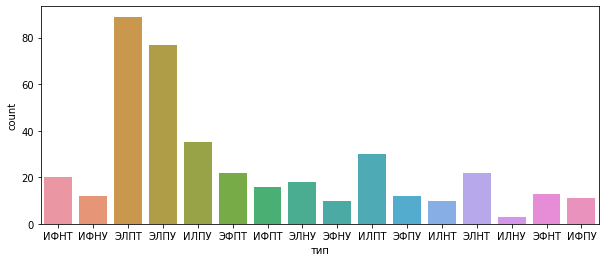

In [147]:
plt.figure(figsize=(10,4))
sns.countplot(x="тип", data=df)

Помня о том, что каждый из 16 типов личности состоит из четырех черт, для которых есть два возможных значения, на следующем графике с кодовыми ячейками представлены круговые диаграммы, которые показывают соотношение между двумя вариантами для каждой из четырех черт.


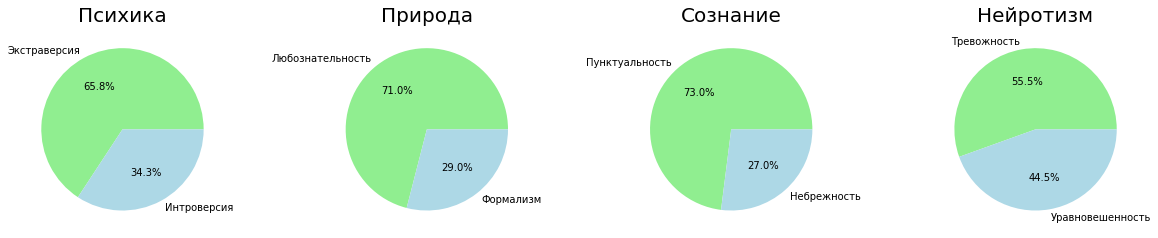

In [148]:
type1 = df['тип'].apply(lambda x: 'Интроверсия' if x[0] == 'И' else 'Экстраверсия')
type2 = df['тип'].apply(lambda x: 'Формализм' if x[1] == 'Ф' else 'Любознательность')
type3 = df['тип'].apply(lambda x: 'Небрежность' if x[2] == 'Н' else 'Пунктуальность')
type4 = df['тип'].apply(lambda x: 'Уравновешенность' if x[3] == 'У' else 'Тревожность')

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace = 0.5)
ax1 = plt.subplot(1, 4, 1)
plt.pie(type1.value_counts(), labels = type1.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax1.set_title('Психика', fontsize=20)

ax2 = plt.subplot(1, 4, 2)
plt.pie(type2.value_counts(), labels = type2.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax2.set_title('Природа', fontsize=20)

ax3 = plt.subplot(1, 4, 3)
plt.pie(type3.value_counts(), labels = type3.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax3.set_title('Сознание', fontsize=20)

ax4 = plt.subplot(1, 4, 4)
plt.pie(type4.value_counts(), labels = type4.value_counts().index, autopct='%1.1f%%', colors = ['lightgreen','lightblue'])
ax4.set_title('Нейротизм', fontsize=20)
plt.show()

В следующем примере кода показано, как реализовать передискретизацию:

In [149]:
df['психика'] = df['психика'].apply(lambda x: 0 if x == 'И' else 1)
df['природа'] = df['природа'].apply(lambda x: 0 if x == 'Ф' else 1)
df['сознание'] = df['сознание'].apply(lambda x: 0 if x == 'Н' else 1)
df['нейротизм'] = df['нейротизм'].apply(lambda x: 0 if x == 'У' else 1)

In [150]:
df

,id,текст,интроверсия/экстраверсия,формализм/любознательность,небрежность/пунктуальность,уравновешенность/тревожность,психика,природа,сознание,нейротизм,тип
0,1,Начнем сначала. На картине изображено 2 лица: ...,35,44,38,65,0,0,0,1,ИФНТ
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",35,44,38,65,0,0,0,1,ИФНТ
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",39,41,47,41,0,0,0,0,ИФНУ
3,4,На картине двое: бабушка и внук. Молодость и с...,39,41,47,41,0,0,0,0,ИФНУ
4,5,"Привет, Маш! Как давно я не писала тебе! Все с...",58,70,58,51,1,1,1,1,ЭЛПТ
...,...,...,...,...,...,...,...,...,...,...,...
395,396,"Сначала я куплю себе большой дом за городом, м...",44,45,46,40,0,0,0,0,ИФНУ
396,397,На картине я вижу мужчину-пахаря. Он со своим ...,58,48,61,59,1,0,1,1,ЭФПТ
397,398,Я не буду спешить с покупками. Я постараюсь вс...,58,48,61,59,1,0,1,1,ЭФПТ
398,399,На картине изображена деревня. Женщина справа ...,39,53,55,38,0,1,1,0,ИЛПУ


In [151]:
posts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/posts.csv')
posts2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/posts_2.csv')

In [152]:
posts.head()

,Unnamed: 0,текст,психика,природа,сознание,нейротизм
0,0,URL и Intj Moment URL SportsCenter не лучшая д...,0,1,0,1
1,1,"Я считаю, что отсутствие меня в этом посте оче...",1,1,1,0
2,2,"хороший один из URL -курса, на который я говор...",0,1,1,0
3,3,"Уважаемый INTP, я наслаждался нашим разговором...",0,1,1,1
4,4,"Вы уволили, что это еще одно глупое заблуждени...",1,1,1,1


In [153]:
def applyMBTI(posts):
  psych = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
  nature = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
  cogn = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
  neuro = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')
  return psych + nature + cogn + neuro

In [154]:
  posts['psych'] = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
  posts['nature'] = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
  posts['cogn'] = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
  posts['neuro'] = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')

In [155]:
posts['тип'] = posts[['psych', 'nature', 'cogn', 'neuro']].agg(''.join, axis=1)
posts = posts.drop(['psych', 'nature', 'cogn', 'neuro'], axis = 1)

In [156]:
posts.rename(columns={'Unnamed: 0':'id'}, inplace = True)

In [157]:
posts

,id,текст,психика,природа,сознание,нейротизм,тип
0,0,URL и Intj Moment URL SportsCenter не лучшая д...,0,1,0,1,ИЛНТ
1,1,"Я считаю, что отсутствие меня в этом посте оче...",1,1,1,0,ЭЛПУ
2,2,"хороший один из URL -курса, на который я говор...",0,1,1,0,ИЛПУ
3,3,"Уважаемый INTP, я наслаждался нашим разговором...",0,1,1,1,ИЛПТ
4,4,"Вы уволили, что это еще одно глупое заблуждени...",1,1,1,1,ЭЛПТ
...,...,...,...,...,...,...,...
4995,4995,"Я просто хотел попробовать, и нужно было место...",0,1,0,1,ИЛНТ
4996,4996,"Вы уверены в этой темной мысли, кажется, из те...",0,1,0,1,ИЛНТ
4997,4997,"Привет всем, что я только что закончил колледж...",1,1,0,0,ЭЛНУ
4998,4998,не нравится говорить о моем более глубоком ощу...,1,1,0,0,ЭЛНУ


In [158]:
posts2['psych'] = posts['психика'].apply(lambda x: 'И' if x==0 else 'Э')
posts2['nature'] = posts['природа'].apply(lambda x: 'Ф' if x==0 else 'Л')
posts2['cogn'] = posts['сознание'].apply(lambda x: 'Н' if x==0 else 'П')
posts2['neuro'] = posts['нейротизм'].apply(lambda x: 'У' if x==0 else 'Т')

In [159]:
posts2['тип'] = posts2[['psych', 'nature', 'cogn', 'neuro']].agg(''.join, axis=1)
posts2 = posts2.drop(['psych', 'nature', 'cogn', 'neuro'], axis = 1)

In [160]:
posts2

,id,текст,психика,природа,сознание,нейротизм,тип
0,10001,"Что ж, это, как оказалось, моя область знаний ...",0,1,0,1,ИЛНТ
1,10002,"Это здорово, теперь я должен записать свой гол...",1,1,0,0,ЭЛПУ
2,10003,Какая самая странная форма путешествия вы испы...,0,1,1,0,ИЛПУ
3,10004,"k Этот звук действительно действительно, но ме...",0,1,0,0,ИЛПТ
4,10005,Escapism World of Warcraft Personality Cafe Чр...,1,1,0,0,ЭЛПТ
...,...,...,...,...,...,...,...
3495,13496,"Для меня это обычно потому, что вы, потенциаль...",0,1,0,0,ЭФНТ
3496,13497,"Даже не Entp, но, черт возьми, вы, черт возьми...",0,0,1,0,ИЛНТ
3497,13498,"Я прочитал всю книгу, мне понравившиеся, она д...",0,1,0,0,ИЛНТ
3498,13499,"Я думаю, что одна вещь, которая недостаточно я...",0,1,0,0,ЭЛНТ


In [161]:
df = df.drop(['интроверсия/экстраверсия', 'формализм/любознательность', 'небрежность/пунктуальность', 'уравновешенность/тревожность'],
             axis = 1)

In [162]:
df = pd.concat([df, posts, posts2], axis=0)
df

,id,текст,психика,природа,сознание,нейротизм,тип
0,1,Начнем сначала. На картине изображено 2 лица: ...,0,0,0,1,ИФНТ
1,2,"Здорово, дружище! Давно не виделись. У меня вс...",0,0,0,1,ИФНТ
2,3,"Привет, Данил! Как дела? Я надеюсь, что все х...",0,0,0,0,ИФНУ
3,4,На картине двое: бабушка и внук. Молодость и с...,0,0,0,0,ИФНУ
4,5,"Привет, Маш! Как давно я не писала тебе! Все с...",1,1,1,1,ЭЛПТ
...,...,...,...,...,...,...,...
3495,13496,"Для меня это обычно потому, что вы, потенциаль...",0,1,0,0,ЭФНТ
3496,13497,"Даже не Entp, но, черт возьми, вы, черт возьми...",0,0,1,0,ИЛНТ
3497,13498,"Я прочитал всю книгу, мне понравившиеся, она д...",0,1,0,0,ИЛНТ
3498,13499,"Я думаю, что одна вещь, которая недостаточно я...",0,1,0,0,ЭЛНТ


In [163]:
# TO DO: translate eng to rus

In [164]:
def removepunct(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [165]:
def removenums(text):
  return re.sub(r'\d+', '', text)


In [166]:
type(df['текст'])

pandas.core.series.Series

Removing nums makes model worse

In [167]:
df['текст'] = df['текст'].str.lower()
df['текст'] = df['текст'].apply(removepunct)
# df['текст'] = df['текст'].apply(removenums)

In [168]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [170]:
import pymorphy2

In [171]:
morph = pymorphy2.MorphAnalyzer()

In [172]:
def applyMorph(text):
  result = []
  for word in text.split(' '):
    p = morph.parse(word)[0]
    result.append(p.normal_form)
  return ' '.join(result)

In [173]:
df['текст'] = df['текст'].apply(applyMorph)

In [174]:
df

,id,текст,психика,природа,сознание,нейротизм,тип
0,1,начать сначала на картина изобразить 2 лицо мо...,0,0,0,1,ИФНТ
1,2,здорово дружище давно не видеться у я всё норм...,0,0,0,1,ИФНТ
2,3,привет данил как дело я надеяться что всё хор...,0,0,0,0,ИФНУ
3,4,на картина двое бабушка и внук молодость и ста...,0,0,0,0,ИФНУ
4,5,привет маш как давно я не писать ты всё свобод...,1,1,1,1,ЭЛПТ
...,...,...,...,...,...,...,...
3495,13496,для я это обычно потому что вы потенциальный д...,0,1,0,0,ЭФНТ
3496,13497,даже не entp но черта взять вы черта взять не ...,0,0,1,0,ИЛНТ
3497,13498,я прочитать весь книга я понравиться она дейст...,0,1,0,0,ИЛНТ
3498,13499,я думать что один вещь который недостаточно яс...,0,1,0,0,ЭЛНТ


In [175]:
from sklearn.utils import resample

d = {}
new_train = pd.DataFrame()
class_list = df['тип'].value_counts().index
avg_class_size = int(np.average(df['тип'].value_counts()))

for mbti_type in class_list:
    d[mbti_type] = df[df['тип'] == mbti_type]
    d[mbti_type] = resample(d[mbti_type], replace = True, n_samples = avg_class_size)
    new_train = pd.concat([new_train, d[mbti_type]])

Следующие две ячейки кода определяют и вызывают функцию, которая создает диаграммы облака слов для каждого из 16 типов личности.

In [176]:
def generate_wordcloud(text, title):
    '''
    Create and generate a word cloud image
    
    Parameters:
        text (str): The text string with all words
        title (str): The title of the word cloud
    '''
    
    wordcloud = WordCloud(background_color="white").generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 15)

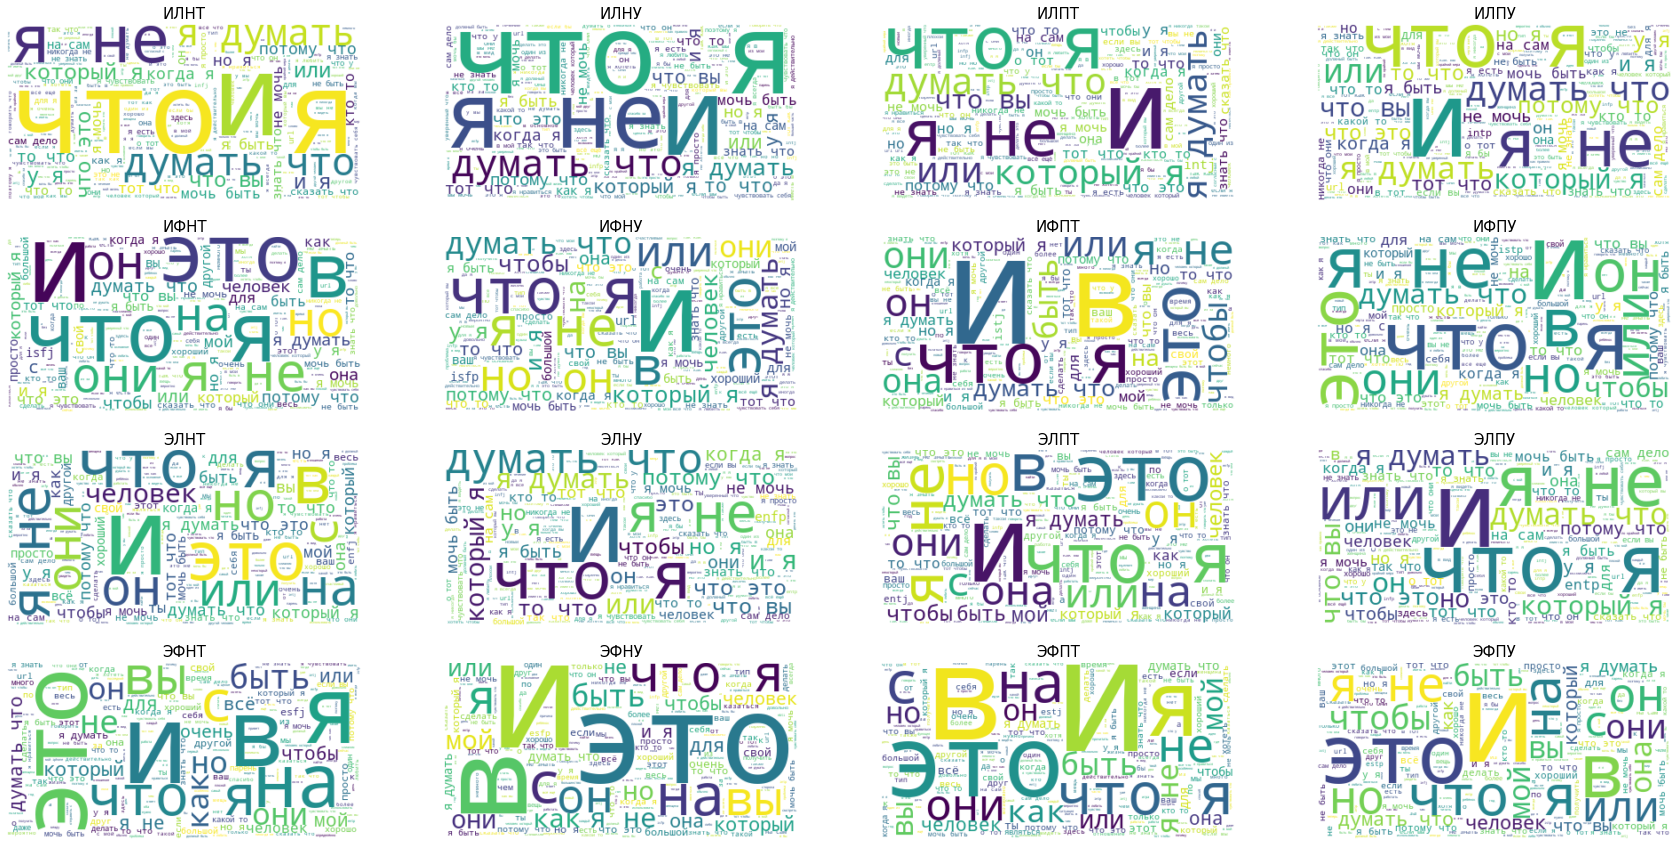

In [177]:
train_by_personality = df.groupby("тип")['текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

От "облака слов" можно увидеть следующее наблюденее: необходимо избавиться от стоп-слов.

## Чистка текста

In [178]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [179]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['очень', 'так', 'это', 'как', 'в', 'я', 'то', 'url']

stop_words.update(new_stopwords)
final_stop_words = set(stop_words)

print(final_stop_words)

{'про', 'куда', 'тут', 'ему', 'надо', 'тогда', 'или', 'сам', 'от', 'больше', 'очень', 'один', 'теперь', 'ж', 'хорошо', 'меня', 'вас', 'ним', 'потому', 'было', 'при', 'на', 'чуть', 'к', 'но', 'нет', 'нас', 'бы', 'уж', 'ну', 'это', 'ведь', 'наконец', 'моя', 'ее', 'была', 'а', 'url', 'уже', 'даже', 'чего', 'то', 'для', 'здесь', 'тоже', 'тебя', 'и', 'из', 'как', 'перед', 'всегда', 'другой', 'более', 'иногда', 'между', 'нельзя', 'вдруг', 'какой', 'будет', 'за', 'себя', 'где', 'чем', 'с', 'был', 'того', 'этот', 'вы', 'почти', 'об', 'впрочем', 'кто', 'о', 'если', 'через', 'же', 'себе', 'потом', 'него', 'хоть', 'быть', 'их', 'над', 'можно', 'мой', 'них', 'вот', 'я', 'два', 'сейчас', 'всех', 'после', 'конечно', 'зачем', 'нее', 'этом', 'ты', 'ни', 'нибудь', 'эту', 'много', 'ей', 'по', 'не', 'она', 'так', 'у', 'всю', 'тот', 'он', 'во', 'ней', 'были', 'будто', 'разве', 'ничего', 'лучше', 'вам', 'им', 'там', 'такой', 'этой', 'они', 'совсем', 'чтобы', 'опять', 'его', 'что', 'да', 'может', 'под', 'те

In [180]:
df['очищенный текст'] = df['текст'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stop_words)]))

In [181]:
df

,id,текст,психика,природа,сознание,нейротизм,тип,очищенный текст
0,1,начать сначала на картина изобразить 2 лицо мо...,0,0,0,1,ИФНТ,начать сначала картина изобразить 2 лицо молод...
1,2,здорово дружище давно не видеться у я всё норм...,0,0,0,1,ИФНТ,здорово дружище давно видеться всё нормально п...
2,3,привет данил как дело я надеяться что всё хор...,0,0,0,0,ИФНУ,привет данил дело надеяться всё последний меся...
3,4,на картина двое бабушка и внук молодость и ста...,0,0,0,0,ИФНУ,картина двое бабушка внук молодость старость б...
4,5,привет маш как давно я не писать ты всё свобод...,1,1,1,1,ЭЛПТ,привет маш давно писать всё свободный время за...
...,...,...,...,...,...,...,...,...
3495,13496,для я это обычно потому что вы потенциальный д...,0,1,0,0,ЭФНТ,обычно потенциальный дружелюбие угодный причин...
3496,13497,даже не entp но черта взять вы черта взять не ...,0,0,1,0,ИЛНТ,entp черта взять черта взять намного хороший в...
3497,13498,я прочитать весь книга я понравиться она дейст...,0,1,0,0,ИЛНТ,прочитать весь книга понравиться действительно...
3498,13499,я думать что один вещь который недостаточно яс...,0,1,0,0,ЭЛНТ,думать вещь который недостаточно ясный заключа...


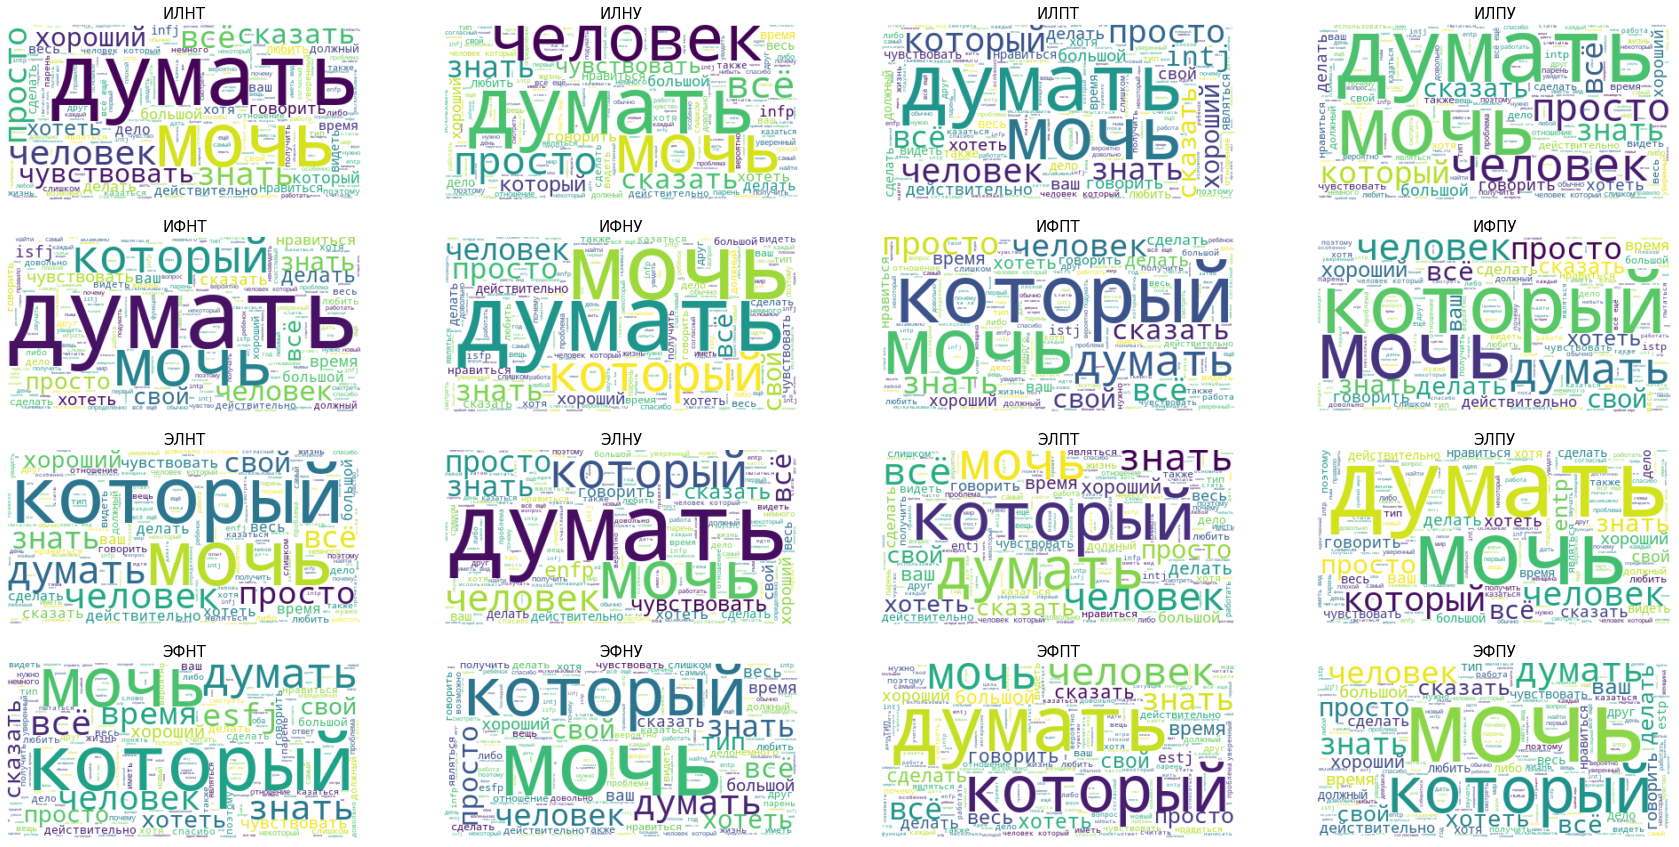

In [182]:
train_by_personality = df.groupby("тип")['очищенный текст'].apply(' '.join).reset_index()

plt.figure(figsize=(30,15))
for i, t in enumerate(train_by_personality['тип']):
    text = train_by_personality.iloc[i,1]
    ax = plt.subplot(4, 4, i+1)
    generate_wordcloud(text, t)
plt.show()

### Векторизация и латентный семантический анализ

Векторизация данных будет проведена частотно-инверсным векторизатором частоты документа, выходом которого является матрица признаков TF-IDF.

Частота термина: обобщает, как часто данное слово появляется в тексте.  
Обратная частота документа: уменьшает количество слов, которые часто встречаются в тексте.

In [183]:
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

Чтобы преодолеть проблему высокой размерности в нашей входной матрице, был выполнен латентный семантический анализ (LSA), метод уменьшения размерности, на матрице TF-IDF с использованием разложения по сингулярным значениям (SVD).

Согласно документации sklearn.decomposition.TruncatedSVD, при выполнении LSA рекомендуется n_components = 100.

In [184]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

Затем мы разделяем данные на X, обучающий набор и тест.

In [185]:
X = df_X[:6230,:]
test = df_X[6230:,:]

#### Построение целевых векторов
Взяв четыре двоичные переменные, составляющие целевой «тип», были построены следующие цели:

- Психика = 0 для интроверта и 1 для экстраверта  
- Природа = 0 для формалиста и 1 для любознательного    
- Сознание = 0 для небрежного и 1 для пунктульного  
- Нейротизм = 0 для уравновешенного и 1 для тревожного  

In [186]:
X

array([[ 1.11638167e-01, -2.31171145e-02, -9.73213139e-02, ...,
         1.20690782e-02, -1.93136005e-04, -4.20919798e-02],
       [ 9.37456833e-02, -3.14743130e-02, -1.28492511e-02, ...,
         1.04017943e-02, -2.22907957e-02,  1.02990576e-03],
       [ 1.27277852e-01, -8.93142923e-02,  2.47252188e-02, ...,
         1.14933435e-02,  1.91713990e-03, -1.02059382e-02],
       ...,
       [ 2.76842931e-01,  1.97269971e-01, -1.40769058e-03, ...,
         6.69022141e-03, -1.17006016e-02,  2.65104297e-02],
       [ 2.87602192e-01, -2.06783827e-02, -4.93178969e-02, ...,
         1.20199039e-02,  1.91980963e-02,  6.18726054e-03],
       [ 3.45270746e-01, -2.87460327e-02, -1.53538255e-02, ...,
        -5.34022481e-03, -1.23073666e-02,  2.05286800e-02]])

In [187]:
df

,id,текст,психика,природа,сознание,нейротизм,тип,очищенный текст
0,1,начать сначала на картина изобразить 2 лицо мо...,0,0,0,1,ИФНТ,начать сначала картина изобразить 2 лицо молод...
1,2,здорово дружище давно не видеться у я всё норм...,0,0,0,1,ИФНТ,здорово дружище давно видеться всё нормально п...
2,3,привет данил как дело я надеяться что всё хор...,0,0,0,0,ИФНУ,привет данил дело надеяться всё последний меся...
3,4,на картина двое бабушка и внук молодость и ста...,0,0,0,0,ИФНУ,картина двое бабушка внук молодость старость б...
4,5,привет маш как давно я не писать ты всё свобод...,1,1,1,1,ЭЛПТ,привет маш давно писать всё свободный время за...
...,...,...,...,...,...,...,...,...
3495,13496,для я это обычно потому что вы потенциальный д...,0,1,0,0,ЭФНТ,обычно потенциальный дружелюбие угодный причин...
3496,13497,даже не entp но черта взять вы черта взять не ...,0,0,1,0,ИЛНТ,entp черта взять черта взять намного хороший в...
3497,13498,я прочитать весь книга я понравиться она дейст...,0,1,0,0,ИЛНТ,прочитать весь книга понравиться действительно...
3498,13499,я думать что один вещь который недостаточно яс...,0,1,0,0,ЭЛНТ,думать вещь который недостаточно ясный заключа...


In [188]:
y = df['тип'][:6230]

y_mind = y.apply(lambda x: 0 if x[0] == 'И' else 1)
y_nature = y.apply(lambda x: 0 if x[1] == 'Ф' else 1)
y_consciousness = y.apply(lambda x: 0 if x[2] == 'Н' else 1)
y_neuroticism = y.apply(lambda x: 0 if x[3] == 'У' else 1)

In [189]:
len(X)

6230

In [190]:
len(test)+len(X)

8900

In [191]:
df_train = df[['id', 'текст', 'психика', 'природа', 'сознание', 'нейротизм']]
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/test.csv')

sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ПолиЛингвистика/random_example.csv')

# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [192]:
df['очищенный текст'] = df['текст'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stop_words)]))

In [193]:
vectorizer = TfidfVectorizer()
df_X = vectorizer.fit_transform(df['очищенный текст'])

In [194]:
svd = TruncatedSVD(n_components = 100)
df_X = svd.fit_transform(df_X)

In [195]:
df_X

array([[ 0.11328845, -0.02323563, -0.08981534, ...,  0.03152399,
        -0.04954647, -0.019206  ],
       [ 0.09451207, -0.03186393, -0.01121813, ...,  0.00700639,
        -0.01318694, -0.00977158],
       [ 0.12841632, -0.08980533,  0.02649335, ...,  0.03184978,
        -0.03307256,  0.0119427 ],
       ...,
       [ 0.01014294,  0.00093573,  0.02680423, ...,  0.00391754,
         0.01889357,  0.01509677],
       [ 0.01186132, -0.00491474,  0.02122491, ..., -0.00973762,
        -0.00161159,  0.04216274],
       [ 0.00093494, -0.00127473,  0.00176012, ...,  0.00276154,
         0.00132833,  0.00662858]])

In [196]:
X = df_X[:8900,:]
test = df_X[8900:,:]

In [197]:
len(test)

311

In [198]:
y = df[:8900]

y_mind = y['психика']
y_nature = y['природа']
y_consciousness = y['сознание']
y_neuroticism = y['нейротизм']

In [199]:
df

,id,текст,психика,природа,сознание,нейротизм,train,очищенный текст
0,1,начать сначала на картина изобразить 2 лицо мо...,0.0,0.0,0.0,1.0,1,начать сначала картина изобразить 2 лицо молод...
1,2,здорово дружище давно не видеться у я всё норм...,0.0,0.0,0.0,1.0,1,здорово дружище давно видеться всё нормально п...
2,3,привет данил как дело я надеяться что всё хор...,0.0,0.0,0.0,0.0,1,привет данил дело надеяться всё последний меся...
3,4,на картина двое бабушка и внук молодость и ста...,0.0,0.0,0.0,0.0,1,картина двое бабушка внук молодость старость б...
4,5,привет маш как давно я не писать ты всё свобод...,1.0,1.0,1.0,1.0,1,привет маш давно писать всё свободный время за...
...,...,...,...,...,...,...,...,...
9206,13807,"Половину отдам на обеспечение интернатов, детс...",NaN,NaN,NaN,NaN,0,"Половину отдам обеспечение интернатов, детских..."
9207,13808,"На мой взгляд, на картине передано чувство пер...",NaN,NaN,NaN,NaN,0,"На взгляд, картине передано чувство переживани..."
9208,13809,Я бы сначала последовал выражению «Кто сам не ...,NaN,NaN,NaN,NaN,0,"Я сначала последовал выражению «Кто дает, тому..."
9209,13810,На картине мы видим огород. На огороде работае...,NaN,NaN,NaN,NaN,0,На картине видим огород. На огороде работает м...


## Тестирование моделей


In [200]:
# Modules for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from mlxtend.classifier import StackingCVClassifier

# Modules for model evaluation and parameter tuning
from sklearn.model_selection import  cross_val_score, GridSearchCV

In [201]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [202]:
from catboost import CatBoostClassifier

In [207]:
LogR_model = LogisticRegression()
RFC_model = RandomForestClassifier()
SVC_model = SVC(probability = True)
XGB_model = XGBClassifier()
Catboost_model = CatBoostClassifier()

category = [(y_mind, "психика"), (y_nature, "природа"), (y_consciousness, "сознание"), (y_neuroticism, "нейротизм")]
models = [(LogR_model, "LOG"), (RFC_model, "RFC"), (SVC_model, 'SVC'), (XGB_model, 'XGB'), (Catboost_model, 'CTB')]

Чтобы сравнить производительность каждой из четырех базовых моделей, был запущен следующий цикл, результаты которого приведены в таблице ниже.

In [208]:
for a in category:
    print("-----", a[1], "-----")
    for b in models:
        score = -1*round(np.average(cross_val_score(b[0], X, a[0], cv = 4, scoring = 'neg_log_loss', n_jobs = 4)),5)
        print(b[1], ": ", score)

----- психика -----
LOG :  0.4775
RFC :  0.49463
SVC :  0.4426
XGB :  0.47263
CTB :  0.46987
----- природа -----
LOG :  0.34288
RFC :  0.35418
SVC :  0.30481
XGB :  0.32768
CTB :  0.3241
----- сознание -----
LOG :  0.49479
RFC :  0.53007
SVC :  0.45828
XGB :  0.47622
CTB :  0.46407
----- нейротизм -----
LOG :  0.57472
RFC :  0.60404
SVC :  0.54022
XGB :  0.57392
CTB :  0.55612


В таблице показаны значения Log Loss для каждой пары модель-целевая категория. Обратите внимание, что в среднем логистическая регрессия превосходит другие, в то время как XGB имеет самую низкую производительность, поэтому лучше исключить эту модель из дальнейшего рассмотрения.

## Делаем прогноз

Создание документов для проверки

В ячейке кода ниже мы определяем функцию, которая соответствует модели, прогнозирует классификацию типа личности для матрицы тренировочных данных и сохраняет файл отправки в домашнем каталоге.

In [209]:
def submission_file(model, file_name):
    '''
    Saves to the home directory a submission file by making MBTI classificatio predictions for the test matrix using the input model.

    Parameters:
        model (sklearn model): The model used to make to make predictions
        file_name (str): The name of the file to be used.
    
    Returns:
        The function does not return an object but rather saves to the home directory a submission file.
    '''

    model.fit(X,y_mind)
    prediction_mind = pd.DataFrame(model.predict(test))
    prediction_mind.columns = ['психика']

    model.fit(X,y_nature)
    prediction_nature = pd.DataFrame(model.predict(test))
    prediction_nature.columns = ['природа']

    model.fit(X,y_consciousness)
    prediction_consciousness = pd.DataFrame(model.predict(test))
    prediction_consciousness.columns = ['сознание']

    model.fit(X,y_neuroticism)
    prediction_neuroticism = pd.DataFrame(model.predict(test))
    prediction_neuroticism.columns = ['нейротизм']
    
    submission = prediction_mind.join([prediction_nature, prediction_consciousness, prediction_neuroticism])
    submission.reset_index(inplace=True)
    submission['id'] = submission['index'] + 13501
    submission.drop('index', axis = 1, inplace = True)
    submission_df = submission[['id','психика', 'природа', 'сознание', 'нейротизм']]
    
    submission_df.to_csv(file_name, index = False)

In [210]:
test

array([[ 0.05724462,  0.00484178,  0.11867421, ..., -0.00207843,
        -0.00519872, -0.0027101 ],
       [ 0.0552045 ,  0.01652276,  0.07957285, ...,  0.00315598,
         0.0132784 ,  0.00147087],
       [ 0.06333551,  0.02905504,  0.07517096, ...,  0.00618424,
         0.01552486, -0.0240874 ],
       ...,
       [ 0.01014294,  0.00093573,  0.02680423, ...,  0.00391754,
         0.01889357,  0.01509677],
       [ 0.01186132, -0.00491474,  0.02122491, ..., -0.00973762,
        -0.00161159,  0.04216274],
       [ 0.00093494, -0.00127473,  0.00176012, ...,  0.00276154,
         0.00132833,  0.00662858]])

In [211]:
# logreg model
models = [(LogR_model, "log_submission.csv")]

for model, file_name in models:
    submission_file(model, file_name)

In [ ]:
# RFC model
models = [(RFC_model, "rfc_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [212]:
# SVC model
models = [(SVC_model, "svc_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [ ]:
# Catboost model
models = [(Catboost_model, "cbt_submission.csv")]

for model, file_name in models:
  submission_file(model, file_name)

In [213]:
testdf = pd.read_csv('/content/svc_submission.csv')
testdf

,id,психика,природа,сознание,нейротизм
0,13501,0.0,1.0,1.0,0.0
1,13502,0.0,1.0,1.0,1.0
2,13503,0.0,1.0,1.0,1.0
3,13504,0.0,1.0,1.0,1.0
4,13505,0.0,1.0,1.0,0.0
...,...,...,...,...,...
306,13807,0.0,1.0,1.0,0.0
307,13808,0.0,1.0,0.0,0.0
308,13809,0.0,1.0,1.0,0.0
309,13810,0.0,1.0,0.0,0.0
